# Updated Random Forest Code

Streamlining the process and ensuring analysis includes appropriate measures.

In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from scipy.stats import norm, sem, t

%matplotlib inline
plt.style.use('seaborn-colorblind')

## Import the data and the question strings

In [2]:
folder='../../ComputationSurveyData/';
XLS = pd.ExcelFile(folder + 'LabeledComputationData.xlsx')
XLS2 = pd.ExcelFile(folder + 'CategorizedQuestions.xlsx')
df = XLS.parse('LabeledComputationData')
questions = XLS2.parse('Sheet1')

### Selecting the question to classify and input features to use to predict classifications

In [47]:
question_to_classify = 'Q1'

feature_subset = questions[((questions['context'] == 'test') |
                            (questions['context'] == 'background') |
                           (questions['context'] == 'demographics')) & 
                           (questions['qtype'] != 'open')];

### Randomly select the training data
Add a new key ```is_train``` to the data frame, which is a random selection of the data

In [48]:
training_proportion = .75
df['is_train'] = np.random.uniform(0, 1, len(df)) <= training_proportion

### Add new keys that factorize our original data set
The classifer requires that the data be represented as numbers, so it will assign a unique integer for each unique string in a given key.

In [49]:
features = []
for ID in feature_subset.id:

    new_header = ID + 'feature'
    df[new_header] = pd.factorize(df[ID])[0]
    features.append(new_header)

### Create two new dataframes, one with the training rows, one with the test rows

In [50]:
train, test = df[df['is_train']==True], df[df['is_train']==False]

### Create two new data frames for the classifications and store the input data
```train[question]``` contains the classes of the data. Before we can use it, we need to convert each result into a digit. 

In [51]:
y = pd.factorize(train[question_to_classify])[0]
y_test = pd.factorize(test[question_to_classify])[0]
X = train[features]
X_test = test[features]

# Rescale the input data
Scaling of the data (using z-scores) ensures that each values for each key are on the same scale so that fits aren't overwhelmed by vastly different scaled variables.

In [52]:
# Scaling to ensure it doesn't behave badly
scaler = StandardScaler()
scaler.fit(X)

# Now apply the transformations to the data:
X = scaler.transform(X)
X_test = scaler.transform(X_test)

### Run the random forest and fit the data

In [53]:
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(n_estimators=24);

# Train the classifier to take the training features, X, and learn how they relate
# to the training classes, y
clf.fit(X, y);

# Apply the classifier we trained to the test data (which, remember, it has never seen before)
pred_y_test = clf.predict(X_test);

### Run analytics on the model

In [54]:
## Confusion Matrix
confusion = confusion_matrix(y_test,pred_y_test)
print('Confusion Matrix:\n',confusion)

## Check accuracy of model on test data
acc_score = accuracy_score(y_test, pred_y_test);
print('Percentage of accurate predictions:\n', acc_score)

## Compute predicted class probabilities
preds = clf.predict_proba(X_test)

## Determine false positive and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])

## Store rates for plotting
dfROC = pd.DataFrame(dict(fpr = fpr, tpr = tpr))

## Compute area under curve of ROC
area_under_curve = auc(fpr,tpr)
print('Area under curve:\n', area_under_curve)

Confusion Matrix:
 [[ 70  55]
 [ 29 181]]
Percentage of accurate predictions:
 0.749253731343
Area under curve:
 0.786895238095


### Plot the ROC curve

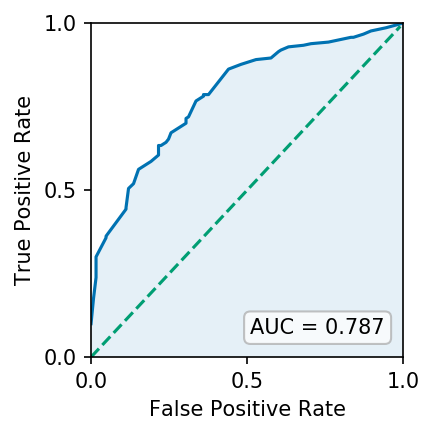

In [56]:
#just to plot guessing line
a = np.arange(0,1,0.01)

bboxprops = {'facecolor':'white', 'pad':0.3, 'boxstyle':'round', 'edgecolor':'darkgrey', 'alpha':0.7}

fig1 = plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

plt.plot(dfROC['fpr'],dfROC['tpr'])
plt.plot(a,a,'--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax1.fill_between(dfROC['fpr'], 0, dfROC['tpr'],alpha=0.1)
ax1.text(0.51, 0.07, 'AUC = '+ str(round(area_under_curve, 3)), bbox = bboxprops)
plt.axis([0,1,0,1])
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])

plt.tight_layout()